<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/FastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix as sklearn_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# imports ของ fastai
from fastai.vision.all import *

# ป้องกัน error จากภาพที่อาจจะไม่สมบูรณ์ (ImageFile.LOAD_TRUNCATED_IMAGES is True)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# กำหนด path ของข้อมูล
base_dir = "/content/drive/MyDrive/dataset/" # ตรวจสอบว่า path นี้ถูกต้อง
train_dir_name = "train" # ชื่อของ subdirectory สำหรับข้อมูล train
valid_dir_name = "valid" # ชื่อของ subdirectory สำหรับข้อมูล validation
test_dir_name = "test"   # ชื่อของ subdirectory สำหรับข้อมูล test

train_path = os.path.join(base_dir, train_dir_name)
valid_path = os.path.join(base_dir, valid_dir_name)
test_path = os.path.join(base_dir, test_dir_name)


# --- ตรวจสอบและเปลี่ยนชื่อไฟล์ (คงไว้จากโค้ดเดิม, ควรจะรันส่วนนี้ก่อนโหลดข้อมูล) ---
def rename_files(directory):
    if not os.path.exists(directory):
        print(f"ไม่พบไดเรกทอรี: {directory}")
        return
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    new_filename = filename.replace('-', '_').replace(' ', '_')
                    if new_filename != filename:
                        try:
                            os.rename(os.path.join(class_path, filename), os.path.join(class_path, new_filename))
                        except OSError as e:
                            print(f"เกิดข้อผิดพลาดในการเปลี่ยนชื่อไฟล์ {filename} ใน {class_path}: {e}")

print("กำลังเปลี่ยนชื่อไฟล์หากจำเป็น...")
if os.path.exists(train_path): rename_files(train_path)
if os.path.exists(valid_path): rename_files(valid_path)
if os.path.exists(test_path): rename_files(test_path)


# --- 4. เตรียมข้อมูลสำหรับ Fastai DataLoaders ---
TARGET_DIMS_FASTAI = (224, 224) # Fastai มักจะใช้ (height, width)
BATCH_SIZE = 32
# CLASSES_TO_AUGMENT = ['Blood', 'Mucus', 'Green'] # จาก Keras, ดูหมายเหตุด้านล่างเกี่ยวกับการทำ conditional augmentation

# ตรวจสอบว่า train_path มีอยู่จริงและมี subdirectories (class) หรือไม่
if not os.path.exists(train_path) or not any(os.path.isdir(os.path.join(train_path, i)) for i in os.listdir(train_path)):
    raise ValueError(f"ไม่พบไดเรกทอรีสำหรับ train: {train_path} หรือไม่มี class subdirectories")

# กำหนด augmentations สำหรับ training set
# aug_transforms ของ Fastai มีชุด augmentations ที่ดีเป็นค่าเริ่มต้น
# พารามิเตอร์ของ Keras: shear_range=0.2, zoom_range=0.2, h_flip=True, rot=30, w_shift=0.2, h_shift=0.2
# aug_transforms: mult (ความเข้มโดยรวม), do_flip, flip_vert, max_rotate, min_scale (สำหรับ RandomResizedCrop หรือ zoom),
#                 max_lighting, max_warp (สำหรับ shear), p_affine, p_lighting
# หมายเหตุ: width/height_shift_range มักจะถูกครอบคลุมโดย RandomResizedCrop หรือสามารถเพิ่มได้ด้วย AffineCoordTfm

# Item transforms (ใช้กับแต่ละภาพก่อนที่จะรวมเป็น batch)
item_tfms = Resize(TARGET_DIMS_FASTAI[0]) # Resize เป็นสี่เหลี่ยมจัตุรัส, หรือส่ง tuple (height, width)

# Batch transforms (ใช้กับ batch ของภาพบน GPU, รวมถึง augmentation และ normalization)
# Augmentations จะถูกใช้กับ training set เท่านั้นโดยค่าเริ่มต้น
batch_tfms_list = [
    *aug_transforms(
        mult=1.0,
        do_flip=True,
        max_rotate=30.0,
        min_scale=0.8,  # สอดคล้องกับ zoom_range สูงสุด 0.2 (เช่น 1-0.2 = 0.8)
        max_warp=0.2    # สอดคล้องกับ shear_range
    ),
    Normalize.from_stats(*imagenet_stats)
]

# สร้าง DataBlock
# สมมติว่า 'train_path' และ 'valid_path' เป็น subdirectories โดยตรงของ 'base_dir' (เช่น dataset/train, dataset/valid)
food_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, # ฟังก์ชันสำหรับดึง item ทั้งหมดจาก source path
    splitter=GrandparentSplitter(train_name=Path(train_path).name, valid_name=Path(valid_path).name), # ตัวแบ่งข้อมูลตามชื่อโฟลเดอร์แม่ของแม่
    get_y=parent_label, # Label คือชื่อของโฟลเดอร์แม่
    item_tfms=item_tfms,
    batch_tfms=batch_tfms_list
)

# สร้าง DataLoaders จาก DataBlock
# source path สำหรับ DataBlock ควรเป็นไดเรกทอรีที่มีโฟลเดอร์ 'train' และ 'valid' อยู่
print(f"กำลังโหลดข้อมูลจาก base_dir: {base_dir}")
dls = food_block.dataloaders(base_dir, bs=BATCH_SIZE)

print(f"Class ที่พบใน Training set: {dls.vocab}")
print(f"จำนวนภาพทั้งหมดใน Training set: {len(dls.train.dataset)}")
print(f"จำนวนภาพทั้งหมดใน Validation set: {len(dls.valid.dataset)}")
NUM_CLASSES = dls.c
if NUM_CLASSES == 0:
    raise ValueError("จำนวน class เป็น 0 ไม่สามารถสร้างโมเดลได้")

# สำหรับ test set
test_dl = None
if os.path.exists(test_path):
    test_files = get_image_files(test_path)
    if test_files:
        # ถ้า test_path มี class subfolders (เหมือน train/valid), โหลดพร้อม label สำหรับการประเมินผล:
        if any(os.path.isdir(os.path.join(test_path, i)) for i in os.listdir(test_path)):
            print(f"ไดเรกทอรี Test ({test_path}) มี class subfolders กำลังสร้าง test DataLoader แบบมี label")
            # สร้าง DataBlock ชั่วคราวสำหรับ test set ถ้ามี labels
            # นี่เป็นวิธีแก้ปัญหาเฉพาะหน้าเล็กน้อยเพื่อให้สามารถใช้โครงสร้างเดียวกันสำหรับ test data ที่มี label
            # ตรวจสอบให้แน่ใจว่า test_path เป็น sibling ของ train_path และ valid_path ภายใต้ base_dir
            test_specific_block = DataBlock(
                blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                # ใช้ splitter แบบกำหนดเองที่เลือกไฟล์ทั้งหมดจาก test_path
                splitter=FuncSplitter(lambda o: Path(o).parent.parent.name == Path(test_path).name),
                get_y=parent_label,
                item_tfms=item_tfms,
                batch_tfms=[Normalize.from_stats(*imagenet_stats)] # สำหรับ test set ใช้แค่ normalization
            )
            try:
                # ส่ง path ไปยัง test directory โดยตรงถ้ามันมีโครงสร้าง class ภายในตัวเอง
                test_dls_labeled = test_specific_block.dataloaders(test_path, bs=BATCH_SIZE, shuffle=False)
                test_dl = test_dls_labeled.train # ใช้ส่วน 'train' ของ dls จำลองนี้เป็น test set ของเรา
                print(f"จำนวนภาพทั้งหมดใน Test set (มี label): {len(test_dl.dataset)}")
            except Exception as e:
                print(f"ไม่สามารถสร้าง test DataLoader แบบมี label จาก {test_path} เนื่องจาก: {e} กำลังลองแบบไม่มี label")
                test_dl = dls.test_dl(test_files, with_labels=False, shuffle=False)
                print(f"จำนวนภาพทั้งหมดใน Test set (ไม่มี label สำหรับ prediction): {len(test_dl.dataset)}")
        else:
            # ถ้า test_path เป็นแค่โฟลเดอร์ของภาพที่ไม่มี class subdirs
            print(f"ไดเรกทอรี Test ({test_path}) ไม่มี class subfolders กำลังสร้าง test DataLoader แบบไม่มี label")
            test_dl = dls.test_dl(test_files, with_labels=False, shuffle=False) # with_labels=False สำหรับ test set ที่ไม่มี label
            print(f"จำนวนภาพทั้งหมดใน Test set (ไม่มี label สำหรับ prediction): {len(test_dl.dataset)}")
    else:
        print(f"ไม่พบไฟล์ภาพในไดเรกทอรี test: {test_path}")
else:
    print(f"ไม่พบไดเรกทอรี test: {test_path} จะข้ามการประเมิน test set")


# --- 5. สร้าง Learner (โมเดล + DataLoaders + Optimizer + Loss Function) ---
checkpoint_dir_fastai = os.path.join(base_dir, 'retailclass_fastai_models/') # โฟลเดอร์สำหรับเก็บโมเดลที่ train ด้วย fastai
if not os.path.exists(checkpoint_dir_fastai):
    os.makedirs(checkpoint_dir_fastai)

# Callbacks
# Keras EarlyStopping patience=10 -> Fastai patience=10
# Keras ModelCheckpoint monitor='val_loss', save_best_only=True -> Fastai SaveModelCallback
# Keras ReduceLROnPlateau factor=0.2, patience=5 -> Fastai ReduceLROnPlateau
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_model_fastai', reset_on_fit=True), # บันทึกโมเดลที่ดีที่สุด
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=10), # หยุดการ train ถ้า val_loss ไม่ดีขึ้น (min_delta ช่วยป้องกันการหยุดเร็วเกินไป)
    ReduceLROnPlateau(monitor='valid_loss', factor=0.2, patience=5) # ลด learning rate ถ้า val_loss ไม่ดีขึ้น
]

# สร้าง learner
# Keras custom head: GlobalAveragePooling2D(), Dropout(0.5), Dense(1024, relu), Dense(NUM_CLASSES, softmax)
# Head เริ่มต้นของ Fastai มักจะดีอยู่แล้ว สำหรับ Dropout(0.5) และ Dense(1024) layer:
# Head เริ่มต้นใช้ `ps=[0.25, 0.5]` สำหรับ Linear layers สองชั้นถ้า `lin_ftrs` ไม่ใช่ None
# เราสามารถส่ง `ps=0.5` เพื่อใช้ dropout นี้กับ linear layer สุดท้ายก่อน classification
# สำหรับ Dense(1024), เราสามารถใช้ `lin_ftrs` ถ้าต้องการระบุขนาดของ intermediate layer
# Head เริ่มต้น: AdaptiveConcatPool2d, Flatten, แล้วก็ block ของ (BatchNorm1d, Dropout, Linear, ReLU) * N + Linear
learn = vision_learner(
    dls,
    resnet50, # โมเดล ResNet50 ที่ pretrain แล้ว
    metrics=[accuracy, error_rate], # metrics ที่ต้องการติดตาม
    cbs=cbs, # callbacks ที่กำหนดไว้
    path=Path(checkpoint_dir_fastai), # path หลักสำหรับ learner, โมเดลจะถูกบันทึกใน 'models' subdirectory
    # เพื่อให้คล้ายกับ Keras head (dropout layer หนึ่งชั้น และ hidden dense layer หนึ่งชั้น):
    # lin_ftrs=[1024], ps=[0.5] # นี่จะหมายถึง hidden layer หนึ่งชั้นขนาด 1024, พร้อม dropout 0.5 ก่อนหน้า
    # ลองใช้โครงสร้าง head เริ่มต้นของ fastai ก่อน สามารถส่ง ps=0.5 สำหรับ dropout ก่อน layer สุดท้าย
    ps = 0.5 # Dropout probability สำหรับ linear layer สุดท้ายใน head เริ่มต้น
)

# เพื่อ freeze layers เหมือน Keras (len(base_model.layers) - 20):
# ResNet50 มี layer groups ที่ตั้งชื่อไว้ใน Fastai
# learn.model[0] คือ backbone learn.model[0][0] คือ stem, learn.model[0][1-4] คือ layer blocks
# `fine_tune` จัดการเรื่องนี้ได้ดี แต่ถ้าต้องการควบคุมเฉพาะเจาะจง:
# `learn.freeze_to(-N)` จะทำให้ N layer groups สุดท้ายของ backbone trainable
# Backbone ของ ResNet50 ใน fastai `vision_learner` มักจะมี parameters แบ่งออกเป็น 2-3 groups โดยค่าเริ่มต้น
# `learn.summary()` ถ้าใช้ PyTorch แบบดิบๆ จะแสดง layers
# สำหรับตอนนี้ เราจะใช้กลยุทธ์ของ `fine_tune`

# --- 6. ฝึกโมเดลโดยใช้ Fastai ---
print("\nกำลังเริ่มการฝึกโมเดลด้วย fastai...")
# Keras: epochs=50, Adam lr=1e-5, fine-tuning ส่วนใหญ่ของ ResNet
# `fine_tune` ของ Fastai:
#   - `epochs`: จำนวน epochs ที่จะ train หลังจาก unfreeze backbone
#   - `base_lr`: learning rate สำหรับ head ที่ randomly initialized และ layers สุดท้ายของ backbone Layers ก่อนหน้าจะได้ LRs ที่น้อยกว่า
#   - `freeze_epochs`: จำนวน epochs ที่จะ train เฉพาะ head โดยที่ backbone ถูก freeze

# หา learning rate ที่เหมาะสม
# print("กำลังค้นหา learning rate ที่แนะนำ...")
# lr_find_res = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# suggested_lr = lr_find_res.valley # หรือ .steep, .slide
# print(f"Learning rate ที่แนะนำ (valley): {suggested_lr}")
# สำหรับตัวอย่างนี้ เราจะใช้ค่าเริ่มต้นทั่วไป
# 1e-5 ของ Keras เป็น LR ที่เล็กสำหรับ layers ที่ส่วนใหญ่ unfreeze แล้ว

num_fine_tune_epochs = 25 # Keras ใช้ 50 ปรับตามความเหมาะสม
initial_freeze_epochs = 5  # Train head สักสองสาม epochs ก่อน
base_learning_rate = 1e-4  # นี่สำหรับ head/later layers; earlier layers จะได้ LR น้อยกว่า

# โค้ด Keras ตั้ง base_model.trainable = True, แล้ว freeze len(base_model.layers)-20
# ซึ่งหมายความว่าหลาย layers trainable ตั้งแต่เริ่มต้น
# `fine_tune` จะ train head ก่อน แล้ว unfreeze ทั้งหมด
# ถ้าคุณต้องการ train โดยมี layers ที่ unfreeze มากกว่าตั้งแต่แรก:
# learn.unfreeze() # Unfreeze backbone layers ทั้งหมด
# learn.fit_one_cycle(num_fine_tune_epochs, lr_max=slice(base_learning_rate/100, base_learning_rate))
# อย่างไรก็ตาม `fine_tune` มักจะถูกแนะนำมากกว่า

print(f"กำลัง Fine-tuning โมเดล: {initial_freeze_epochs} epochs สำหรับ head, จากนั้น {num_fine_tune_epochs} epochs สำหรับโมเดลทั้งหมด")
learn.fine_tune(
    num_fine_tune_epochs,
    base_lr=base_learning_rate,
    freeze_epochs=initial_freeze_epochs
)

print("\nการฝึกโมเดลเสร็จสิ้น")
# โมเดลที่ดีที่สุด 'best_model_fastai.pth' ถูกบันทึกโดย SaveModelCallback ใน learn.path/models/

# --- 7. ประเมินผลและแสดงผล ---
print("\nกำลังโหลดโมเดลที่ดีที่สุดเพื่อการประเมินผล...")
learn.load('best_model_fastai') # โหลดจาก learn.path/models/best_model_fastai.pth
print("โหลดโมเดล 'best_model_fastai' ที่ดีที่สุดแล้ว")

if test_dl:
    print("\nกำลังประเมินผลบน test set...")
    if test_dl.with_labels: # ถ้า test set มี labels
        test_loss, test_acc, test_err = learn.validate(dl=test_dl) # ประเมินผลบน test_dl
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc * 100:.2f}%")
        print(f"Test Error Rate: {test_err * 100:.2f}%")

        print("\nกำลังสร้าง classification report และ confusion matrix สำหรับ test set...")
        interp = ClassificationInterpretation.from_learner(learn, dl=test_dl) # สร้าง object สำหรับ interpretation

        # Classification Report
        # `interp.preds` คือ probabilities, `interp.targs` คือ true labels, `interp.decoded` คือ predicted class indices
        y_pred_indices = interp.decoded.numpy()
        y_true_indices = interp.targs.numpy()
        class_names = dls.vocab # หรือ learn.dls.vocab (ชื่อ class ทั้งหมด)

        print("\nClassification Report (Test Set):")
        try:
            report = classification_report(y_true_indices, y_pred_indices,
                                           labels=np.arange(len(class_names)), # labels คือ 0 ถึง N-1 classes
                                           target_names=class_names, zero_division=0)
            print(report)
        except Exception as e:
            print(f"เกิดข้อผิดพลาดในการสร้าง classification report: {e}")
            print(f"Unique true labels: {np.unique(y_true_indices)}")
            print(f"Unique predicted labels: {np.unique(y_pred_indices)}")

        # Confusion Matrix
        print("\nConfusion Matrix (Test Set):")
        interp.plot_confusion_matrix(figsize=(10, 8), cmap="Blues", normalize=False) # พล็อต confusion matrix ของ Fastai
        plt.xticks(rotation=45, ha='right') # ปรับการหมุนของ x-axis labels
        plt.yticks(rotation=0) # ปรับการหมุนของ y-axis labels
        plt.title("Confusion Matrix (Test Set - กราฟจาก Fastai)") # ตั้งชื่อกราฟ
        plt.tight_layout() # ปรับ layout ให้พอดี
        plt.show()

        # ทางเลือกในการใช้ Seaborn เพื่อสไตล์ที่สอดคล้องกัน (ถ้าต้องการ)
        # conf_matrix_data = interp.confusion_matrix()
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(conf_matrix_data, annot=True, fmt="d", cmap="Blues",
        #             xticklabels=class_names, yticklabels=class_names, cbar=True)
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.title('Confusion Matrix (Test Set - Seaborn)')
        # plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
        # plt.tight_layout()
        # plt.show()

    else: # test_dl ไม่มี label
        print("Test DataLoader ไม่มี label ไม่สามารถสร้าง classification report หรือการประเมินผลแบบเต็มรูปแบบได้")
        print("ตัวอย่างการ predict บน test data ที่ไม่มี label (สำหรับ 5 ภาพแรก):")
        test_preds_unlabeled, _ = learn.get_preds(dl=test_dl) # ดึง predictions
        predicted_indices_unlabeled = torch.argmax(test_preds_unlabeled, dim=1).numpy() # หา class ที่มี probability สูงสุด
        predicted_labels_unlabeled = [dls.vocab[i] for i in predicted_indices_unlabeled] # แปลง indices เป็นชื่อ class
        for i, (fname, pred_label) in enumerate(zip(test_dl.items[:5], predicted_labels_unlabeled[:5])): # แสดงผล 5 ภาพแรก
            print(f"ไฟล์: {Path(fname).name}, Predicted: {pred_label}")
else:
    print("Test DataLoader (test_dl) ไม่พร้อมใช้งาน จะข้ามการประเมิน test set")


# พล็อต training history
print("\nกำลังพล็อตกราฟ training history (จาก fastai learner recorder)...")
if learn.recorder:
    learn.recorder.plot_loss() # พล็อต training และ validation loss
    plt.suptitle("Training & Validation Loss vs. Epochs (Fastai)") # ตั้งชื่อกราฟหลัก
    plt.show()

    learn.recorder.plot_metrics() # พล็อต metrics ทั้งหมด (เช่น accuracy, error_rate) vs. epochs
    plt.suptitle("Metrics vs. Epochs (Fastai)") # ตั้งชื่อกราฟหลัก
    plt.show()
else:
    print("ไม่มี training history ถูกบันทึกใน learner object")

print("\n--- สิ้นสุดสคริปต์การแปลงเป็น Fastai ---")

# --- หมายเหตุเกี่ยวกับการทำ Conditional Augmentation (เหมือน `CLASSES_TO_AUGMENT` ของ Keras) ---
# โค้ด Fastai ด้านบนใช้ augmentations (`aug_transforms`) กับ training set *ทั้งหมด*
# ซึ่งเป็นวิธีปฏิบัติมาตรฐาน โค้ด Keras เดิมใน `CustomDataSequence` ใช้ augmentations
# แบบมีเงื่อนไขกับ class ที่ระบุ ('Blood', 'Mucus', 'Green') ใน training data (และยังใช้กับ
# validation/test data ด้วย ซึ่งเป็นวิธีที่ไม่ปกติอย่างมาก)
#
# เพื่อให้ได้ conditional augmentation *สำหรับ TRAINING SET เท่านั้น* ใน Fastai:
# นี่เป็นเรื่องที่ซับซ้อนกว่าและมักจะต้องสร้าง `Transform` แบบกำหนดเอง
#
# ตัวอย่างโครงร่างของ ItemTransform แบบกำหนดเองสำหรับ conditional augmentation:
# ```python
# # from fastai.vision.augment import RandTransform, Flip, Rotate, Brightness, Contrast # etc.
# #
# # class ConditionalAugment(ItemTransform):
# #     def __init__(self, classes_to_augment_names, vocab, p=0.5):
# #         store_attr()
# #         self.aug_specific_classes = L(cls for cls in vocab if cls in classes_to_augment_names).map(vocab.o2i)
# #         # กำหนด pipeline ของ augmentation สำหรับ class เหล่านี้โดยเฉพาะ
# #         # นี่เป็นตัวอย่าง transforms; ใช้ transforms ที่คุณต้องการ
# #         self.specific_augs = Pipeline([
# #             Flip(p=0.5), Rotate(max_deg=20, p=p), Brightness(max_lighting=0.3, p=p)
# #         ])
# #
# #     def encodes(self, x): # x มักจะเป็น (PILImage, TensorCategory) เมื่อใช้ get_y
# #         img, label_idx = x
# #         if label_idx in self.aug_specific_classes:
# #             # ใช้ augmentation เฉพาะเมื่อภาพนั้นเป็นของ class ที่ระบุ
# #             # self.specific_augs จะรันใน training mode (split_idx=0) โดยค่าเริ่มต้นที่นี่
# #             return self.specific_augs(img), label_idx
# #         return img, label_idx # ไม่ทำ augmentation สำหรับ class อื่นๆ
# #
# # # จากนั้น ใน DataBlock ของคุณ:
# # # conditional_aug_tfm = ConditionalAugment(CLASSES_TO_AUGMENT, dls.vocab) # ต้องมี dls.vocab ก่อน
# # # คุณจะต้องสร้าง dls หนึ่งครั้งเพื่อดึง vocab จากนั้นสร้างใหม่อีกครั้งพร้อมกับ transform นี้
# # # หรือ รวมมันเข้ากับ batch_tfms ถ้ามันถูกออกแบบมาให้ทำงานกับ batches
# # # วิธีที่ง่ายกว่าอาจจะเป็นการใช้ใน `after_item` ถ้ามันทำงานกับ single items
# #
# # # food_block = DataBlock(
# # #     blocks=(ImageBlock, CategoryBlock),
# # #     get_items=get_image_files,
# # #     splitter=GrandparentSplitter(train_name=Path(train_path).name, valid_name=Path(valid_path).name),
# # #     get_y=parent_label,
# # #     item_tfms=[Resize(TARGET_DIMS_FASTAI[0]), conditional_aug_tfm], # ใช้หลังจาก resize
# # #     batch_tfms=[Normalize.from_stats(*imagenet_stats)] # Normalize ที่ระดับ batch เท่านั้น
# # # )
# ```
# วิธีนี้ต้องการการ implement และทดสอบอย่างระมัดระวัง สำหรับกรณีส่วนใหญ่
# การทำ augmentation กับ training set ทั้งหมดให้ผลลัพธ์ที่ดีในการ regularization

กำลังเปลี่ยนชื่อไฟล์หากจำเป็น...
กำลังโหลดข้อมูลจาก base_dir: /content/drive/MyDrive/dataset/
Class ที่พบใน Training set: ['Blood', 'Diarrhea', 'Green', 'Mucus', 'Normal', 'Yellow']
จำนวนภาพทั้งหมดใน Training set: 3350
จำนวนภาพทั้งหมดใน Validation set: 418
ไดเรกทอรี Test (/content/drive/MyDrive/dataset/test) มี class subfolders กำลังสร้าง test DataLoader แบบมี label
ไม่สามารถสร้าง test DataLoader แบบมี label จาก /content/drive/MyDrive/dataset/test เนื่องจาก: list index out of range กำลังลองแบบไม่มี label
จำนวนภาพทั้งหมดใน Test set (ไม่มี label สำหรับ prediction): 423


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.9MB/s]



กำลังเริ่มการฝึกโมเดลด้วย fastai...
กำลัง Fine-tuning โมเดล: 5 epochs สำหรับ head, จากนั้น 25 epochs สำหรับโมเดลทั้งหมด


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.867558,2.148462,0.205742,0.794258,07:05
1,2.317976,1.567483,0.444976,0.555024,02:14
2,1.815717,1.174229,0.617225,0.382775,02:12
3,1.470025,1.038976,0.657895,0.342105,02:14
4,1.282139,0.842870,0.736842,0.263158,02:13


Better model found at epoch 0 with valid_loss value: 2.1484620571136475.
Better model found at epoch 1 with valid_loss value: 1.567482590675354.
Better model found at epoch 2 with valid_loss value: 1.1742289066314697.
Better model found at epoch 3 with valid_loss value: 1.0389763116836548.
Better model found at epoch 4 with valid_loss value: 0.8428695201873779.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.154514,0.860410,0.741627,0.258373,02:19
1,1.154971,0.808647,0.741627,0.258373,02:16
2,1.141425,0.793261,0.744019,0.255981,02:17
3,1.045871,0.759101,0.767943,0.232057,02:18
4,0.993643,0.739406,0.775120,0.224880,02:17
5,0.974845,0.703563,0.777512,0.222488,02:20
6,0.933736,0.715536,0.775120,0.224880,02:16
7,0.816839,0.655370,0.796651,0.203349,02:14


Better model found at epoch 0 with valid_loss value: 0.8604096174240112.
Better model found at epoch 1 with valid_loss value: 0.8086472749710083.
Better model found at epoch 2 with valid_loss value: 0.7932610511779785.
Better model found at epoch 3 with valid_loss value: 0.759101152420044.
Better model found at epoch 4 with valid_loss value: 0.7394062876701355.
Better model found at epoch 5 with valid_loss value: 0.7035629153251648.
Better model found at epoch 7 with valid_loss value: 0.65537029504776.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.154514,0.860410,0.741627,0.258373,02:19
1,1.154971,0.808647,0.741627,0.258373,02:16
2,1.141425,0.793261,0.744019,0.255981,02:17
3,1.045871,0.759101,0.767943,0.232057,02:18
4,0.993643,0.739406,0.775120,0.224880,02:17
5,0.974845,0.703563,0.777512,0.222488,02:20
6,0.933736,0.715536,0.775120,0.224880,02:16
7,0.816839,0.655370,0.796651,0.203349,02:14
8,0.817722,0.625072,0.794258,0.205742,02:15
9,0.759734,0.648388,0.796651,0.203349,02:15


Better model found at epoch 8 with valid_loss value: 0.6250721216201782.
Better model found at epoch 11 with valid_loss value: 0.6202969551086426.
Better model found at epoch 12 with valid_loss value: 0.5929548144340515.
Better model found at epoch 15 with valid_loss value: 0.5863213539123535.
Better model found at epoch 17 with valid_loss value: 0.5823078155517578.
Better model found at epoch 18 with valid_loss value: 0.5719287395477295.
Better model found at epoch 22 with valid_loss value: 0.5548850893974304.

การฝึกโมเดลเสร็จสิ้น

กำลังโหลดโมเดลที่ดีที่สุดเพื่อการประเมินผล...
โหลดโมเดล 'best_model_fastai' ที่ดีที่สุดแล้ว

กำลังประเมินผลบน test set...


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


AttributeError: with_labels

ไดเรกทอรี Test (/content/drive/MyDrive/dataset/test) มี class subfolders กำลังสร้าง test DataLoader แบบมี label
สร้าง test DataLoader (มี label) สำเร็จ มี 423 ภาพ, vocab: ['Blood', 'Diarrhea', 'Green', 'Mucus', 'Normal', 'Yellow']

กำลังประเมินผลบน test set...
Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...

1. การทำนายผล (Predictions) และแสดงตัวอย่าง:



   แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):


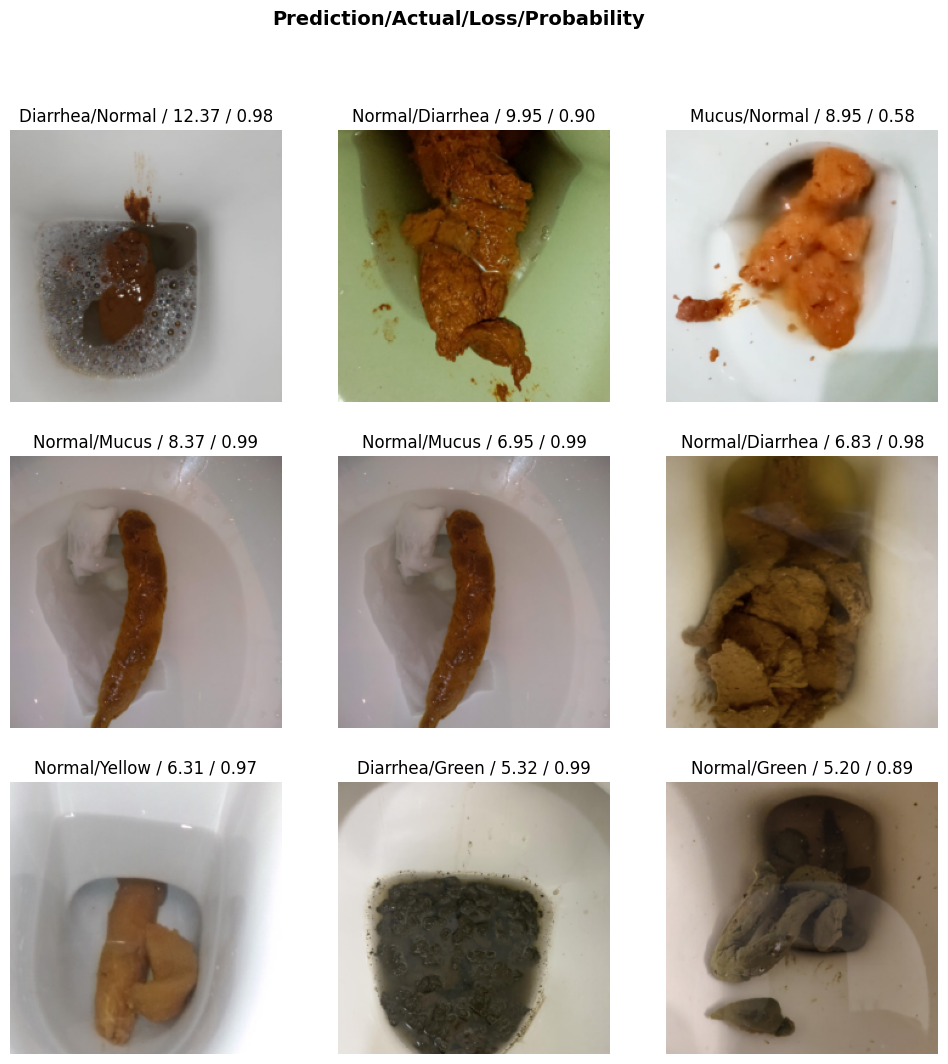


2. Confusion Matrix:


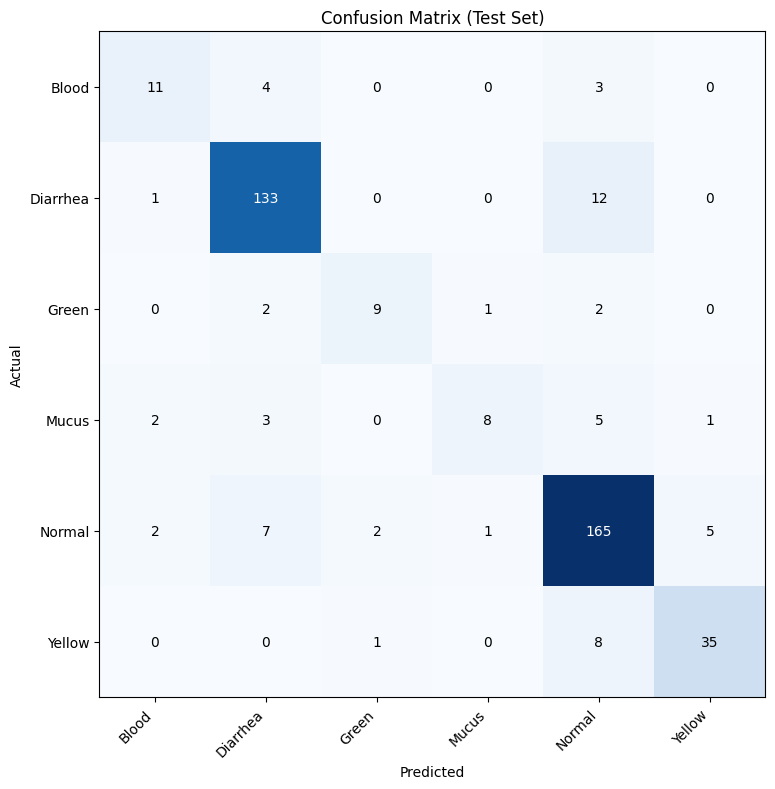


3. Classification Report (ถ้าต้องการ):


AttributeError: 'ClassificationInterpretation' object has no attribute 'decoded'

In [8]:
# ... (ส่วน imports และ path definitions เหมือนเดิม) ...
# ... (ส่วน item_tfms เหมือนเดิม) ...

test_dl = None
if os.path.exists(test_path):
    test_files = get_image_files(test_path)
    if test_files:
        # ตรวจสอบว่า test_path มี subfolders ที่เป็นชื่อ class หรือไม่
        if any(os.path.isdir(os.path.join(test_path, i)) for i in os.listdir(test_path)):
            print(f"ไดเรกทอรี Test ({test_path}) มี class subfolders กำลังสร้าง test DataLoader แบบมี label")

            # สร้าง DataBlock สำหรับ test set โดยเฉพาะ
            test_specific_block = DataBlock(
                blocks=(ImageBlock, CategoryBlock),        # Input เป็นภาพ, Output เป็น Category
                get_items=get_image_files,               # ฟังก์ชันดึงไฟล์ภาพ
                splitter=RandomSplitter(valid_pct=0.0, seed=42), # ให้ข้อมูลทั้งหมดเป็น training set (ไม่มี validation set)
                get_y=parent_label,                      # ดึง label จากชื่อโฟลเดอร์แม่ (ชื่อ class)
                item_tfms=item_tfms,                     # item transforms ที่กำหนดไว้
                batch_tfms=[Normalize.from_stats(*imagenet_stats)] # batch transforms (เฉพาะ Normalization สำหรับ test)
            )
            try:
                # สร้าง DataLoaders object ชั่วคราวโดยใช้ test_path เป็น source
                # ข้อมูลทั้งหมดจาก test_path จะถูกโหลดเข้าไปใน .train ของ temp_dls
                temp_dls = test_specific_block.dataloaders(
                    test_path, # Source คือ test_path โดยตรง
                    bs=BATCH_SIZE,
                    shuffle=False, # ไม่จำเป็นต้อง shuffle test set
                    drop_last=False # ใช้ข้อมูลทั้งหมดแม้ batch สุดท้ายจะไม่เต็ม
                )
                test_dl = temp_dls.train # test_dl ของเราคือ .train ของ DataLoaders ชั่วคราวนี้

                if hasattr(test_dl, 'vocab') and len(test_dl.vocab) > 0:
                    print(f"สร้าง test DataLoader (มี label) สำเร็จ มี {len(test_dl.dataset)} ภาพ, vocab: {test_dl.vocab}")
                    # หลังจากนี้ test_dl พร้อมสำหรับ learn.validate(dl=test_dl) และ ClassificationInterpretation
                else:
                    print(f"สร้าง test DataLoader จาก {test_path} แล้ว แต่ดูเหมือนจะไม่มี vocab/labels ที่ถูกต้อง")
                    test_dl = None

            except Exception as e:
                print(f"ไม่สามารถสร้าง test DataLoader แบบมี label จาก {test_path} เนื่องจาก: {e}")
                # (ส่วน Fallback ถ้าต้องการสร้างแบบไม่มี label จาก dls หลัก)
                if 'dls' in locals() and dls is not None:
                     test_dl = dls.test_dl(test_files, with_labels=False, shuffle=False)
                     print(f"สร้าง test DataLoader (ไม่มี label) จาก dls หลัก จำนวน {len(test_dl.items)} ภาพ")
                else:
                    print("ไม่สามารถสร้าง test_dl แบบไม่มี label ได้ เนื่องจาก dls หลักยังไม่ได้ถูกสร้าง")
                    test_dl = None
        else:
            # กรณี test_path ไม่มี subfolders (ไม่มี labels)
            print(f"ไดเรกทอรี Test ({test_path}) ไม่มี class subfolders กำลังสร้าง test DataLoader แบบไม่มี label")
            if 'dls' in locals() and dls is not None:
                test_dl = dls.test_dl(test_files, with_labels=False, shuffle=False)
                print(f"สร้าง test DataLoader (ไม่มี label) จำนวน {len(test_dl.items)} ภาพ")
            else:
                print("ไม่สามารถสร้าง test_dl แบบไม่มี label ได้ เนื่องจาก dls หลักยังไม่ได้ถูกสร้าง")
                test_dl = None
    else:
        print(f"ไม่พบไฟล์ภาพในไดเรกทอรี test: {test_path}")
else:
    print(f"ไม่พบไดเรกทอรี test: {test_path}")

# --- หลังจากนี้คือส่วน Predict และ Confusion Matrix ---
# (โค้ดส่วนนี้จะเหมือนกับที่ให้ไปก่อนหน้า โดยจะมีการตรวจสอบ if test_dl and has_labels)

if test_dl:
    print("\nกำลังประเมินผลบน test set...")

    has_labels = hasattr(test_dl, 'vocab') and test_dl.vocab is not None and len(test_dl.vocab) > 0

    if has_labels:
        print("Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...")

        print("\n1. การทำนายผล (Predictions) และแสดงตัวอย่าง:")
        interp = ClassificationInterpretation.from_learner(learn, dl=test_dl) # <--- ตรวจสอบว่า learn ถูก define และ train แล้ว

        print("\n   แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):")
        interp.plot_top_losses(k=9, figsize=(12,12))
        plt.show()

        print("\n2. Confusion Matrix:")
        interp.plot_confusion_matrix(
            figsize=(10, 8),
            cmap="Blues",
            normalize=False,
            plot_txt=True
        )
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.title("Confusion Matrix (Test Set)")
        plt.tight_layout()
        plt.show()

        print("\n3. Classification Report (ถ้าต้องการ):")
        y_pred_indices_report = interp.decoded.numpy()
        y_true_indices_report = interp.targs.numpy()
        class_names = learn.dls.vocab # หรือ dls.vocab ถ้า dls หลักถูกสร้างแล้วและมี vocab เดียวกัน

        try:
            report = classification_report(y_true_indices_report, y_pred_indices_report,
                                           labels=np.arange(len(class_names)),
                                           target_names=class_names, zero_division=0)
            print(report)
        except Exception as e:
            print(f"เกิดข้อผิดพลาดในการสร้าง classification report: {e}")

    else: # กรณี test_dl ไม่มี labels
        print("Test DataLoader ไม่มี label, ไม่สามารถสร้าง Confusion Matrix หรือ Classification Report ได้")
        print("ตัวอย่างการ predict บน test data ที่ไม่มี label (สำหรับ 5 ภาพแรก):")
        # ... (โค้ดส่วน predict แบบไม่มี label เหมือนเดิม) ...
else:
    print("Test DataLoader (test_dl) ไม่พร้อมใช้งาน หรือไม่ถูกสร้างอย่างถูกต้อง")


กำลังประเมินผลบน test set...
Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...

   ผลการประเมินโดยรวมบน Test Set:


Better model found at epoch 0 with valid_loss value: 0.8368794322013855.
     Test Loss: 0.5639
     Test Accuracy: 83.69%
     Test Error Rate: 16.31%

1. กำลังเตรียมข้อมูลสำหรับการแสดงผล (ClassificationInterpretation)...



2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):


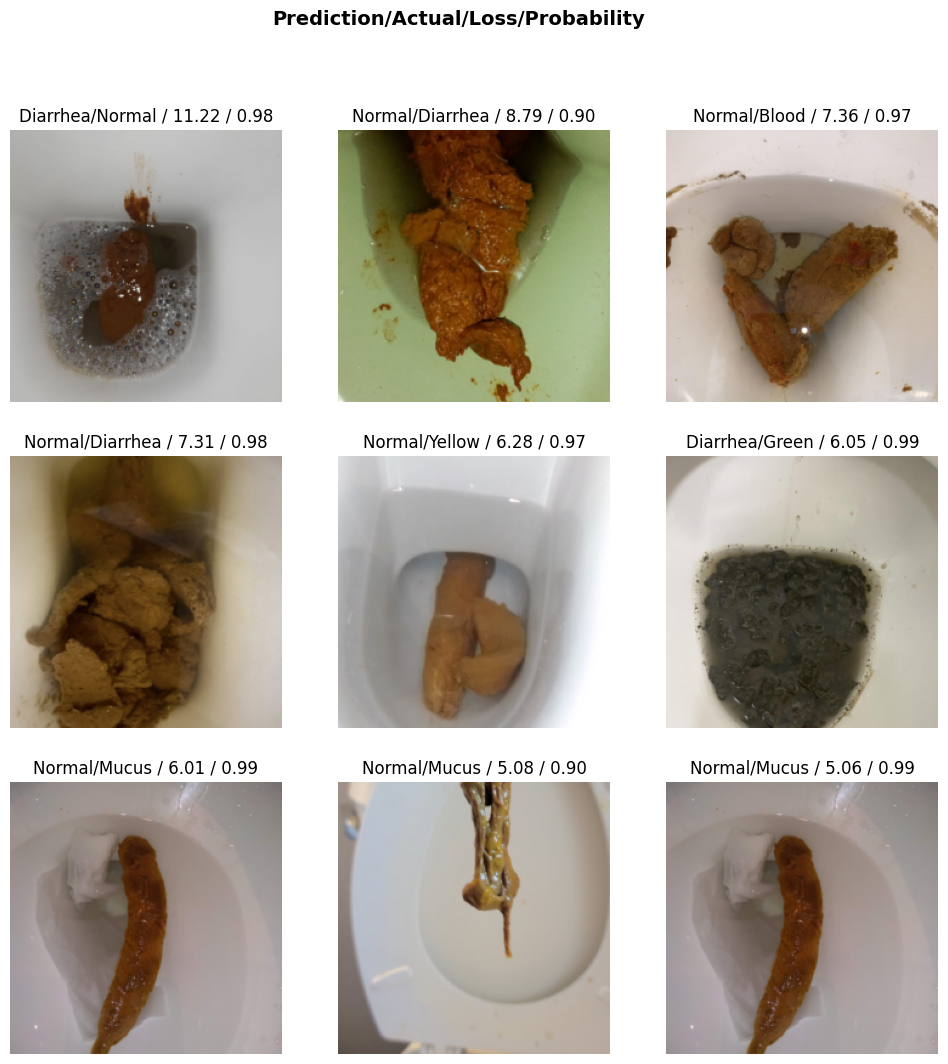


3. Confusion Matrix:


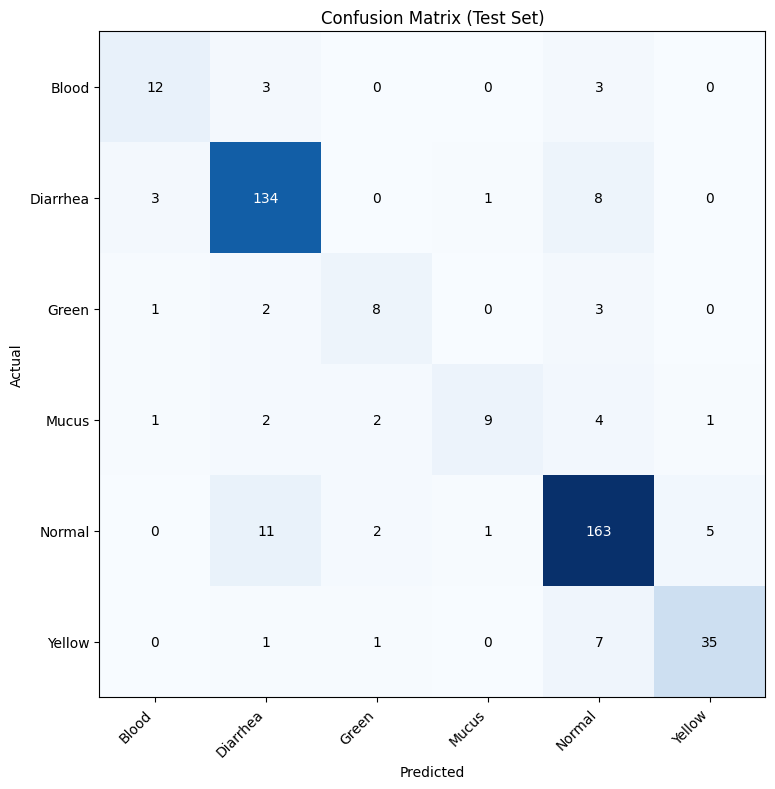


4. Classification Report:
   เกิดข้อผิดพลาดในการสร้าง Classification Report: 'ClassificationInterpretation' object has no attribute 'preds'

--- สิ้นสุดส่วนแสดงผลลัพธ์ ---


In [12]:
import numpy as np
import torch # สำหรับ torch.argmax
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from fastai.vision.all import * # สำหรับ ClassificationInterpretation และอื่นๆ

# --- สมมติว่าคุณมี learn และ test_dl ที่พร้อมใช้งานแล้ว ---
# learn = ... (Learner object ของคุณที่ฝึกและโหลด best model แล้ว)
# test_dl = ... (Test DataLoader ของคุณที่มี labels)
# class_names_from_vocab = learn.dls.vocab # หรือ dls.vocab ถ้า dls หลักถูกสร้างและมี vocab เดียวกัน

# --- ส่วนที่ 7: ประเมินผลและแสดงผล ---

if test_dl:
    print("\nกำลังประเมินผลบน test set...")

    # ตรวจสอบว่า test_dl มี label หรือไม่
    # (ในที่นี้เราสมมติว่า test_dl มี label เพื่อแสดง confusion matrix และ report)
    has_labels = hasattr(test_dl, 'vocab') and test_dl.vocab is not None and len(test_dl.vocab) > 0

    if has_labels:
        print("Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...")

        # 0. ประเมินผลโดยรวมบน Test Set (Optional, แต่แนะนำให้ทำ)
        print("\n   ผลการประเมินโดยรวมบน Test Set:")
        try:
            test_loss, test_acc, test_err_rate = learn.validate(dl=test_dl)
            print(f"     Test Loss: {test_loss:.4f}")
            print(f"     Test Accuracy: {test_acc * 100:.2f}%")
            print(f"     Test Error Rate: {test_err_rate * 100:.2f}%")
        except Exception as e_validate:
            print(f"     เกิดข้อผิดพลาดในการรัน learn.validate(): {e_validate}")


        # 1. สร้าง Object ClassificationInterpretation
        print("\n1. กำลังเตรียมข้อมูลสำหรับการแสดงผล (ClassificationInterpretation)...")
        try:
            interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
        except Exception as e_interp:
            print(f"   เกิดข้อผิดพลาดในการสร้าง ClassificationInterpretation: {e_interp}")
            print("   ไม่สามารถแสดง Top Losses, Confusion Matrix, หรือ Classification Report ได้")
            # ถ้า interp สร้างไม่ได้ ก็ออกจากส่วนนี้
            interp = None # ตั้งเป็น None เพื่อให้ส่วนล่างข้ามไป

        if interp:
            # 2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses)
            print("\n2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):")
            try:
                interp.plot_top_losses(k=9, figsize=(12,12))
                plt.show()
            except Exception as e_top_losses:
                print(f"   เกิดข้อผิดพลาดในการพล็อต Top Losses: {e_top_losses}")

            # 3. แสดง Confusion Matrix
            print("\n3. Confusion Matrix:")
            try:
                interp.plot_confusion_matrix(
                    figsize=(10, 8),
                    cmap="Blues",
                    normalize=False, # แสดงเป็นจำนวนภาพ (ถ้า True จะแสดงเป็นสัดส่วน)
                    plot_txt=True    # แสดงตัวเลขในแต่ละช่อง
                )
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.title("Confusion Matrix (Test Set)")
                plt.tight_layout()
                plt.show()
            except Exception as e_conf_matrix:
                print(f"   เกิดข้อผิดพลาดในการพล็อต Confusion Matrix: {e_conf_matrix}")


            # 4. แสดง Classification Report
            print("\n4. Classification Report:")
            try:
                y_pred_probs_report = interp.preds
                y_pred_indices_report = torch.argmax(y_pred_probs_report, dim=1).numpy()
                y_true_indices_report = interp.targs.numpy()

                class_names = None
                if hasattr(learn.dls, 'vocab') and len(learn.dls.vocab) > 0:
                    class_names = learn.dls.vocab
                elif hasattr(test_dl, 'vocab') and len(test_dl.vocab) > 0: # ลองดึงจาก test_dl โดยตรง
                    class_names = test_dl.vocab
                # เพิ่ม dls หลักถ้ามี
                elif 'dls' in locals() and hasattr(dls, 'vocab') and len(dls.vocab) > 0:
                    class_names = dls.vocab


                if class_names is not None and len(class_names) > 0:
                    # ตรวจสอบจำนวนคลาสที่แท้จริงในข้อมูล labels
                    unique_labels_in_data = np.unique(np.concatenate((y_true_indices_report, y_pred_indices_report)))
                    num_unique_labels = np.max(unique_labels_in_data) + 1

                    labels_for_report = np.arange(num_unique_labels)
                    target_names_for_report = list(class_names) if len(class_names) >= num_unique_labels else None

                    if target_names_for_report and len(target_names_for_report) > num_unique_labels:
                        # ถ้า class_names มีจำนวนคลาสมากกว่า unique labels ที่พบในข้อมูลจริง ให้ตัด class_names ให้พอดี
                        target_names_for_report = target_names_for_report[:num_unique_labels]
                    elif not target_names_for_report and len(class_names) < num_unique_labels :
                        print(f"  คำเตือน: จำนวน class_names ({len(class_names)}) ไม่เพียงพอสำหรับ unique labels ({num_unique_labels}) ที่พบในข้อมูล จะแสดง report โดยไม่มี target names.")


                    report = classification_report(y_true_indices_report, y_pred_indices_report,
                                                   labels=labels_for_report,
                                                   target_names=target_names_for_report,
                                                   zero_division=0)
                    print(report)
                else:
                    print("  ไม่สามารถหา class_names ที่ถูกต้องได้ จะลองสร้าง report โดยไม่มี target names")
                    unique_labels_in_data = np.unique(np.concatenate((y_true_indices_report, y_pred_indices_report)))
                    report_no_names = classification_report(y_true_indices_report, y_pred_indices_report,
                                                        labels=np.arange(np.max(unique_labels_in_data)+1),
                                                        zero_division=0)
                    print(report_no_names)

            except Exception as e_class_report:
                print(f"   เกิดข้อผิดพลาดในการสร้าง Classification Report: {e_class_report}")
                if 'y_true_indices_report' in locals():
                    print(f"     Unique true labels: {np.unique(y_true_indices_report)}")
                if 'y_pred_indices_report' in locals():
                    print(f"     Unique predicted labels: {np.unique(y_pred_indices_report)}")

    else: # กรณี test_dl ไม่มี labels
        print("Test DataLoader ไม่มี label, ไม่สามารถสร้าง Confusion Matrix หรือ Classification Report ได้")
        print("ตัวอย่างการ predict บน test data ที่ไม่มี label (สำหรับ 5 ภาพแรก):")

        # (ส่วนโค้ดสำหรับ predict บน test data ที่ไม่มี label สามารถนำมาจากโค้ดเต็มก่อนหน้านี้ได้)
        # ตัวอย่างสั้นๆ:
        if hasattr(test_dl, 'items') and len(test_dl.items) > 0:
            test_item_paths = test_dl.items[:5] # เอาแค่ 5 ภาพแรก
            for img_path in test_item_paths:
                try:
                    pred_class, _, _ = learn.predict(img_path)
                    print(f"   ไฟล์: {Path(img_path).name}, Predicted Class: {pred_class}")
                except Exception as e_pred_unlabeled:
                    print(f"   เกิดข้อผิดพลาดในการทำนายภาพ {Path(img_path).name}: {e_pred_unlabeled}")
        else:
            print("   ไม่สามารถเข้าถึงรายการไฟล์ใน test_dl เพื่อแสดงตัวอย่างการ predict ได้")

else:
    print("Test DataLoader (test_dl) ไม่พร้อมใช้งาน หรือไม่ถูกสร้างอย่างถูกต้อง")

print("\n--- สิ้นสุดส่วนแสดงผลลัพธ์ ---")


กำลังประเมินผลบน test set...
Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...

   ผลการประเมินโดยรวมบน Test Set:


Better model found at epoch 0 with valid_loss value: 0.8486997485160828.
     Test Loss: 0.5563
     Test Accuracy: 84.87%
     Test Error Rate: 15.13%

1. กำลังดึง Predictions และ True Labels จาก Learner...


   ดึง Predictions และ True Labels สำเร็จแล้ว

2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):


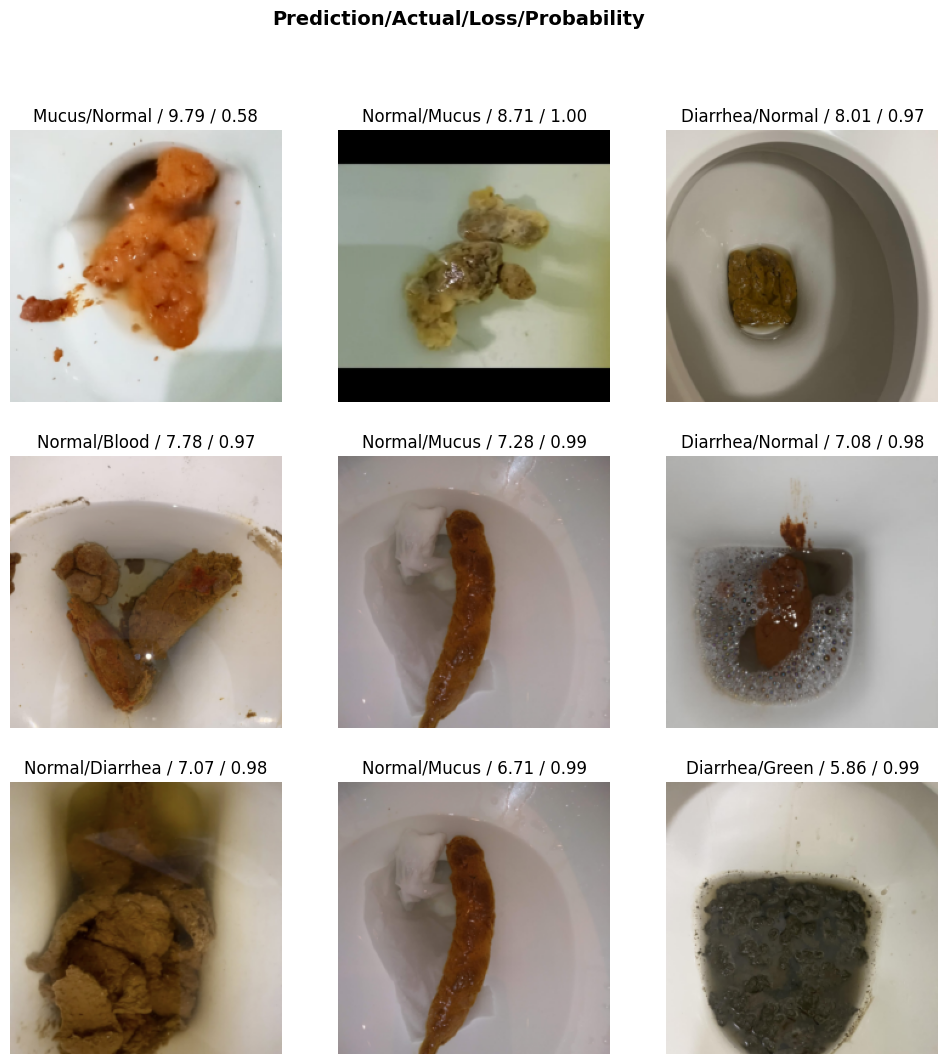


3. Confusion Matrix:


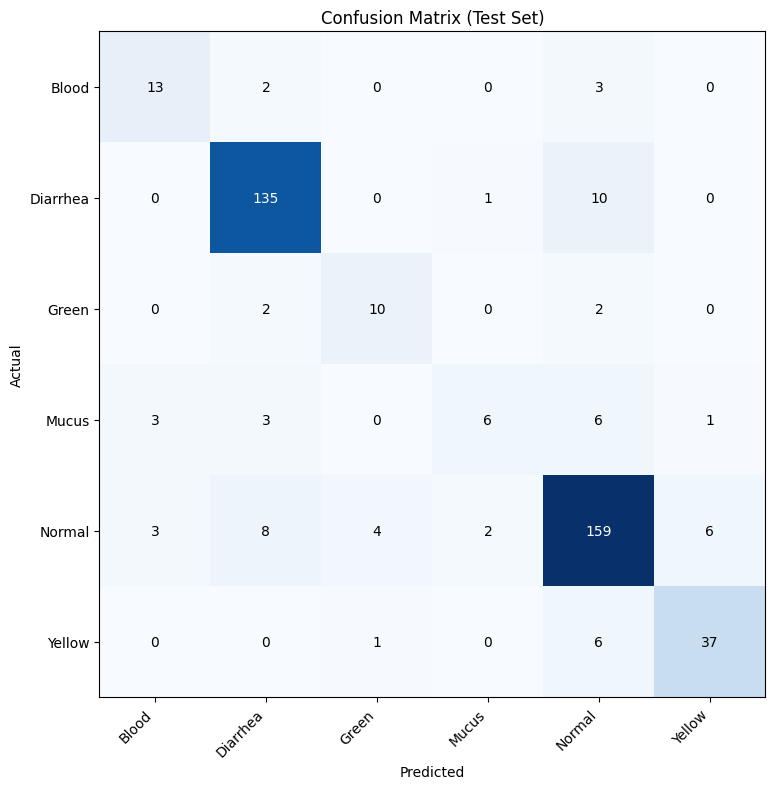


4. Classification Report:
              precision    recall  f1-score   support

       Blood       0.63      0.67      0.65        18
    Diarrhea       0.87      0.90      0.89       146
       Green       0.83      0.71      0.77        14
       Mucus       0.80      0.42      0.55        19
      Normal       0.86      0.90      0.88       182
      Yellow       0.83      0.80      0.81        44

    accuracy                           0.85       423
   macro avg       0.81      0.73      0.76       423
weighted avg       0.85      0.85      0.85       423


--- สิ้นสุดส่วนแสดงผลลัพธ์ ---


In [13]:
import numpy as np
import torch # สำหรับ torch.argmax
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from fastai.vision.all import *

# --- สมมติว่าคุณมี learn และ test_dl ที่พร้อมใช้งานแล้ว ---
# learn = ... (Learner object ของคุณที่ฝึกและโหลด best model แล้ว)
# test_dl = ... (Test DataLoader ของคุณที่มี labels)
# class_names_from_vocab = learn.dls.vocab # หรือ dls.vocab

# --- ส่วนที่ 7: ประเมินผลและแสดงผล ---

if test_dl:
    print("\nกำลังประเมินผลบน test set...")
    has_labels = hasattr(test_dl, 'vocab') and test_dl.vocab is not None and len(test_dl.vocab) > 0

    if has_labels:
        print("Test DataLoader มี labels, กำลังทำการประเมินผลและแสดงผล...")

        # 0. ประเมินผลโดยรวมบน Test Set
        print("\n   ผลการประเมินโดยรวมบน Test Set:")
        try:
            test_loss, test_acc, test_err_rate = learn.validate(dl=test_dl)
            print(f"     Test Loss: {test_loss:.4f}")
            print(f"     Test Accuracy: {test_acc * 100:.2f}%")
            print(f"     Test Error Rate: {test_err_rate * 100:.2f}%")
        except Exception as e_validate:
            print(f"     เกิดข้อผิดพลาดในการรัน learn.validate(): {e_validate}")

        # 1. ดึง Predictions และ True Labels โดยตรงจาก Learner
        print("\n1. กำลังดึง Predictions และ True Labels จาก Learner...")
        try:
            # learn.get_preds(dl=test_dl) จะคืนค่า (predictions_probabilities, true_target_indices)
            y_pred_probs_all, y_true_indices_all = learn.get_preds(dl=test_dl)
            y_pred_indices_all = torch.argmax(y_pred_probs_all, dim=1).numpy() # Predicted indices
            y_true_indices_all_np = y_true_indices_all.numpy() # True indices (as numpy)

            # สร้าง ClassificationInterpretation โดยส่ง predictions และ targets ที่ได้มา
            # นี่เป็นวิธีหนึ่งถ้า interp.from_learner ไม่ได้ให้ attribute ที่ต้องการโดยตรง
            # หรือเราสามารถใช้ y_pred_indices_all และ y_true_indices_all_np กับ classification_report ได้เลย
            interp = ClassificationInterpretation.from_learner(learn, dl=test_dl) # ยังคงสร้าง interp เพื่อใช้ plot_top_losses และ plot_confusion_matrix

            print("   ดึง Predictions และ True Labels สำเร็จแล้ว")

        except Exception as e_get_preds:
            print(f"   เกิดข้อผิดพลาดในการดึง Predictions/True Labels: {e_get_preds}")
            print("   ไม่สามารถดำเนินการต่อในส่วนแสดงผล chi tiết ได้")
            # ถ้า get_preds ไม่สำเร็จ ก็อาจจะต้องออกจากส่วนนี้
            y_pred_indices_all = None # ตั้งเป็น None เพื่อให้ส่วนล่างข้ามไป

        if y_pred_indices_all is not None: # ตรวจสอบว่าดึง pred/targs มาได้หรือไม่
            # 2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses) - ใช้ interp เดิมได้
            if interp:
                print("\n2. แสดงตัวอย่างภาพที่โมเดลทำนายผิดพลาดมากที่สุด (Top Losses):")
                try:
                    interp.plot_top_losses(k=9, figsize=(12,12))
                    plt.show()
                except Exception as e_top_losses:
                    print(f"   เกิดข้อผิดพลาดในการพล็อต Top Losses: {e_top_losses}")

                # 3. แสดง Confusion Matrix - ใช้ interp เดิมได้
                print("\n3. Confusion Matrix:")
                try:
                    interp.plot_confusion_matrix(
                        figsize=(10, 8),
                        cmap="Blues",
                        normalize=False,
                        plot_txt=True
                    )
                    plt.xticks(rotation=45, ha='right')
                    plt.yticks(rotation=0)
                    plt.title("Confusion Matrix (Test Set)")
                    plt.tight_layout()
                    plt.show()
                except Exception as e_conf_matrix:
                    print(f"   เกิดข้อผิดพลาดในการพล็อต Confusion Matrix: {e_conf_matrix}")

            # 4. แสดง Classification Report - ใช้ y_pred_indices_all และ y_true_indices_all_np ที่ดึงมาใหม่
            print("\n4. Classification Report:")
            try:
                class_names = None
                if hasattr(learn.dls, 'vocab') and len(learn.dls.vocab) > 0:
                    class_names = learn.dls.vocab
                elif hasattr(test_dl, 'vocab') and len(test_dl.vocab) > 0:
                    class_names = test_dl.vocab
                elif 'dls' in locals() and hasattr(dls, 'vocab') and len(dls.vocab) > 0:
                    class_names = dls.vocab

                if class_names is not None and len(class_names) > 0:
                    unique_labels_in_data = np.unique(np.concatenate((y_true_indices_all_np, y_pred_indices_all)))
                    num_unique_labels = np.max(unique_labels_in_data) + 1
                    labels_for_report = np.arange(num_unique_labels)
                    target_names_for_report = list(class_names) if len(class_names) >= num_unique_labels else None

                    if target_names_for_report and len(target_names_for_report) > num_unique_labels:
                        target_names_for_report = target_names_for_report[:num_unique_labels]
                    elif not target_names_for_report and class_names and len(class_names) < num_unique_labels:
                         print(f"  คำเตือน: จำนวน class_names ({len(class_names)}) ไม่เพียงพอสำหรับ unique labels ({num_unique_labels}) จะแสดง report โดยไม่มี target names.")

                    report = classification_report(y_true_indices_all_np, y_pred_indices_all,
                                                   labels=labels_for_report,
                                                   target_names=target_names_for_report,
                                                   zero_division=0)
                    print(report)
                else:
                    print("  ไม่สามารถหา class_names ที่ถูกต้องได้ จะลองสร้าง report โดยไม่มี target names")
                    unique_labels_in_data = np.unique(np.concatenate((y_true_indices_all_np, y_pred_indices_all)))
                    report_no_names = classification_report(y_true_indices_all_np, y_pred_indices_all,
                                                        labels=np.arange(np.max(unique_labels_in_data)+1),
                                                        zero_division=0)
                    print(report_no_names)

            except Exception as e_class_report:
                print(f"   เกิดข้อผิดพลาดในการสร้าง Classification Report: {e_class_report}")
                print(f"     Unique true labels: {np.unique(y_true_indices_all_np)}")
                print(f"     Unique predicted labels: {np.unique(y_pred_indices_all)}")
    else:
        # ... (ส่วน test_dl ไม่มี labels เหมือนเดิม) ...
        print("Test DataLoader ไม่มี label, ไม่สามารถสร้าง Confusion Matrix หรือ Classification Report ได้")
else:
    print("Test DataLoader (test_dl) ไม่พร้อมใช้งาน หรือไม่ถูกสร้างอย่างถูกต้อง")

print("\n--- สิ้นสุดส่วนแสดงผลลัพธ์ ---")

In [14]:
import os
from fastai.vision.all import * # หรือ import ที่จำเป็นสำหรับ Learner ของคุณ

# --- สมมติว่าคุณมี 'learn' object ที่ฝึกเสร็จแล้ว ---
# learn = ... (Learner object ของคุณ)

# --- ส่วนที่ 8: การบันทึกโมเดล (Save Model) ---

# 1. กำหนด Path และชื่อไฟล์สำหรับบันทึกโมเดล
save_model_dir = "/content/drive/MyDrive/dataset/saved_models_tf_f1"
model_filename = "fastaiv1" # FastAI จะเพิ่ม .pth ให้เอง

# 2. สร้างไดเรกทอรีสำหรับบันทึกโมเดล ถ้ายังไม่มี
try:
    os.makedirs(save_model_dir, exist_ok=True)
    print(f"ไดเรกทอรีสำหรับบันทึกโมเดล: '{save_model_dir}' พร้อมใช้งานแล้วหรือถูกสร้างขึ้นใหม่")
except OSError as error:
    print(f"เกิดข้อผิดพลาดในการสร้างไดเรกทอรี '{save_model_dir}': {error}")
    # อาจจะหยุดการทำงานถ้าสร้างไดเรกทอรีไม่ได้
    # raise # Uncomment to stop if directory creation fails

# 3. บันทึกโมเดล
#    เมธอด .save() จะบันทึก state ของโมเดล (weights) และ optimizer (ถ้ามี)
#    ไฟล์จะถูกบันทึกใน learn.path/learn.model_dir/ชื่อไฟล์.pth
#    ดังนั้น เราจะต้องตั้งค่า learn.path และ learn.model_dir ชั่วคราว หรือส่ง path เต็มไปให้

# วิธีที่ 1: ตั้งค่า learn.path และ learn.model_dir ชั่วคราว (แนะนำเพื่อให้ SaveModelCallback ทำงานได้สอดคล้องกันด้วย)
# ถ้าคุณได้ตั้งค่า path ให้กับ Learner ตอนสร้างแล้ว (เช่น path=Path(checkpoint_dir_fastai))
# และ checkpoint_dir_fastai คือ path ที่คุณต้องการ save จริงๆ คุณอาจจะไม่ต้องทำขั้นตอนนี้
# แต่ถ้า path ที่ต้องการ save แตกต่างจากที่ตั้งไว้ใน Learner ตอนสร้าง:

# เก็บ path เดิมไว้ (ถ้ามี)
# original_path = learn.path
# original_model_dir = learn.model_dir

# ตั้งค่า path ใหม่สำหรับ Learner object ชั่วคราวเพื่อการ save นี้
# learn.path = Path(save_model_dir).parent # ให้ learn.path เป็น parent ของ model_dir
# learn.model_dir = Path(save_model_dir).name # ให้ learn.model_dir เป็นชื่อโฟลเดอร์สุดท้าย

# try:
#     print(f"\nกำลังบันทึกโมเดล '{model_filename}.pth' ไปยัง '{save_model_dir}'...")
#     learn.save(model_filename) # FastAI จะบันทึกไปที่ learn.path/learn.model_dir/model_filename.pth
#     print(f"โมเดลถูกบันทึกเรียบร้อยแล้วที่: {learn.path/learn.model_dir/model_filename}.pth")
# except Exception as e:
#     print(f"เกิดข้อผิดพลาดในการบันทึกโมเดล: {e}")
# finally:
#     # คืนค่า path เดิม (ถ้ามีการเปลี่ยนแปลง)
#     learn.path = original_path
#     learn.model_dir = original_model_dir


# วิธีที่ 2: ใช้ learn.export() เพื่อบันทึกโมเดลทั้งหมด (รวมโครงสร้างและ DataLoaders state)
#    วิธีนี้เหมาะสำหรับการ inference บนเครื่องอื่นที่ไม่จำเป็นต้องมีโค้ด DataBlock เดิม
#    ไฟล์ที่ได้จะเป็น .pkl
#    learn.export() จะบันทึกไปที่ learn.path/ 'export.pkl' โดย default
#    ถ้าต้องการ path อื่น อาจจะต้อง copy ไฟล์หลัง export หรือดูว่ามี argument path ให้ใส่หรือไม่

# วิธีที่ 3 (ง่ายกว่าสำหรับการ save weights ไปยัง path ที่กำหนดโดยตรง ถ้าไม่ต้องการเปลี่ยน learn.path):
#    คือการใช้ torch.save โดยตรงกับ state_dict ของโมเดล แต่จะต้องรู้วิธีโหลดกลับเอง
#    วิธีของ FastAI ที่แนะนำคือการใช้ learn.save() ซึ่งจะจัดการเรื่อง optimizer state ด้วย

# *** วิธีที่แนะนำและตรงไปตรงมาที่สุดสำหรับการ save ไปยัง path ที่ต้องการโดยไม่ยุ่งกับ learn.path มากนัก
# คือการใช้ SaveModelCallback ในระหว่างการฝึก หรือถ้าฝึกเสร็จแล้ว ให้ใช้ learn.save()
# โดยปกติ learn.save('my_model_name') จะเซฟไปที่ learn.path/'models'/'my_model_name.pth'

# ดังนั้น ถ้าคุณต้องการเซฟไปยัง path ที่กำหนดเองจริงๆ หลังจากฝึกเสร็จแล้ว:
# คุณสามารถใช้ learn.save() เพื่อเซฟไปยัง default location ของ learner ก่อน
# แล้วค่อย copy หรือ move ไฟล์ไปยัง path ที่คุณต้องการ
# หรือถ้าคุณต้องการให้ไฟล์ถูกสร้างที่ path นั้นเลย:

# ตรวจสอบว่า `learn` object ได้ถูกสร้างและฝึกแล้ว
if 'learn' in locals() and learn is not None:
    try:
        # สร้าง Path object สำหรับไฟล์ที่จะบันทึก
        model_save_path_full = Path(save_model_dir) / f"{model_filename}.pth"

        print(f"\nกำลังบันทึก state ของโมเดล (weights) ไปยัง: {model_save_path_full}...")
        # FastAI's learn.save() จะบันทึก model (weights) และ optimizer state
        # มันจะใช้ learn.path และ learn.model_dir ดังนั้นเราต้องจัดการเรื่องนี้
        # หรือเราสามารถบันทึกเฉพาะ model's state_dict ด้วย PyTorch

        # วิธีที่ 1: บันทึกเฉพาะ model weights ด้วย PyTorch (จะไม่รวม optimizer state)
        # torch.save(learn.model.state_dict(), model_save_path_full)
        # print(f"Model weights ถูกบันทึกเรียบร้อยแล้วที่: {model_save_path_full}")
        # หมายเหตุ: เวลาโหลดกลับจะต้องสร้างโครงสร้างโมเดลที่เหมือนกัน แล้ว learn.model.load_state_dict(torch.load(model_save_path_full))

        # วิธีที่ 2: ใช้ learn.save() แต่ต้องจัดการ path ของ Learner (อาจจะซับซ้อนถ้าไม่ได้ตั้งไว้แต่แรก)
        # โดยปกติ `SaveModelCallback` ที่ใส่ไว้ใน `cbs` ตอนสร้าง `Learner` จะทำงานได้ดีกว่า
        # และจะเซฟ best model ไปยัง `learn.path/learn.model_dir` (เช่น `checkpoint_dir_fastai` ที่คุณตั้งไว้)
        # ถ้าคุณต้องการเซฟ *อีกครั้ง* ไปยังที่อื่นหลังจากฝึกเสร็จ:

        # ถ้า checkpoint_dir_fastai คือ path ที่คุณตั้งค่าไว้ใน Learner
        # และ best_model_fastai.pth คือโมเดลที่ดีที่สุดที่ SaveModelCallback บันทึกไว้
        best_model_source_path = Path(learn.path) / learn.model_dir / 'best_model_fastai.pth'

        if best_model_source_path.exists():
            import shutil
            try:
                shutil.copyfile(best_model_source_path, model_save_path_full)
                print(f"โมเดลที่ดีที่สุด ('best_model_fastai.pth') ถูกคัดลอกไปที่: {model_save_path_full}")
            except Exception as e_copy:
                print(f"เกิดข้อผิดพลาดในการคัดลอกโมเดล: {e_copy}")
                print("จะลองใช้วิธี learn.save() โดยตรงกับชื่อไฟล์ที่ระบุ (อาจจะอยู่ใน default model_dir ของ learner)")
                try:
                    learn.save(model_filename) # จะเซฟไปที่ learn.path/learn.model_dir/fastaiv1.pth
                    # คุณอาจจะต้องย้ายไฟล์นี้ไปยัง path ที่ต้องการอีกที
                    default_saved_path = Path(learn.path) / learn.model_dir / f"{model_filename}.pth"
                    print(f"โมเดลถูกบันทึก (อาจจะที่ default location): {default_saved_path}")
                    if default_saved_path != model_save_path_full and default_saved_path.exists():
                        shutil.move(default_saved_path, model_save_path_full)
                        print(f"โมเดลถูกย้ายไปยัง: {model_save_path_full}")

                except Exception as e_save:
                     print(f"เกิดข้อผิดพลาดในการใช้ learn.save('{model_filename}'): {e_save}")
        else:
            print(f"ไม่พบไฟล์ best model ที่ {best_model_source_path}")
            print("จะลองใช้วิธี learn.save() โดยตรงกับชื่อไฟล์ที่ระบุ")
            try:
                learn.save(model_filename) # จะเซฟไปที่ learn.path/learn.model_dir/fastaiv1.pth
                default_saved_path = Path(learn.path) / learn.model_dir / f"{model_filename}.pth"
                print(f"โมเดลถูกบันทึก (อาจจะที่ default location): {default_saved_path}")
                if default_saved_path.exists() and default_saved_path != model_save_path_full:
                     import shutil
                     shutil.move(default_saved_path, model_save_path_full)
                     print(f"โมเดลถูกย้ายไปยัง: {model_save_path_full}")
                elif default_saved_path == model_save_path_full:
                     print(f"โมเดลถูกบันทึกเรียบร้อยแล้วที่: {model_save_path_full}")


            except Exception as e_save_direct:
                print(f"เกิดข้อผิดพลาดในการใช้ learn.save('{model_filename}'): {e_save_direct}")


    except NameError:
        print("Error: 'learn' object is not defined. กรุณาตรวจสอบว่าคุณได้สร้างและฝึก Learner object แล้ว")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดไม่คาดฝันในการบันทึกโมเดล: {e}")

else:
    print("ตัวแปร 'learn' (Learner object) ยังไม่ได้ถูกสร้างขึ้น กรุณาสร้างและฝึกโมเดลก่อนทำการบันทึก")

ไดเรกทอรีสำหรับบันทึกโมเดล: '/content/drive/MyDrive/dataset/saved_models_tf_f1' พร้อมใช้งานแล้วหรือถูกสร้างขึ้นใหม่

กำลังบันทึก state ของโมเดล (weights) ไปยัง: /content/drive/MyDrive/dataset/saved_models_tf_f1/fastaiv1.pth...
โมเดลที่ดีที่สุด ('best_model_fastai.pth') ถูกคัดลอกไปที่: /content/drive/MyDrive/dataset/saved_models_tf_f1/fastaiv1.pth
